# Contents
* [Introduction](#Introduction)
* [Imports and configuration](#Imports-and-configuration)
* [Setup](#Setup)
* [Alpha](#Alpha)
* [Discussion](#Discussion)

# Introduction

This is a post hoc tuning after seeing disappointing holdout results. We dropped ridge earlier for simplicity and speed, but now it's back in.

Since I'm close to wrapping up at this point, we'll do a quick tune and won't stop to evaluate too much.

In [1]:
from time import time

notebook_begin_time = time()

# set random seeds

from os import environ
from random import seed as random_seed
from numpy.random import seed as np_seed
from tensorflow.random import set_seed


def reset_seeds(seed: int) -> None:
    """Utility function for resetting random seeds"""
    environ["PYTHONHASHSEED"] = str(seed)
    random_seed(seed)
    np_seed(seed)
    set_seed(seed)


reset_seeds(SEED := 2022)
del environ
del random_seed
del np_seed
del set_seed
del reset_seeds

In [2]:
# extensions
%load_ext autotime
%load_ext lab_black
%load_ext nb_black

In [3]:
# core
import numpy as np
import pandas as pd
from scipy.stats import loguniform

# utility
from copy import deepcopy
from gc import collect as gc_collect

# faster sklearn
from sklearnex import patch_sklearn

patch_sklearn()
del patch_sklearn

import swifter

# typing
from typing import Dict, List, Sequence

# other sklearn
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedGroupKFold

# params
from scipy.stats import loguniform, uniform

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib widget

sns.set_context("notebook")

# full display of rows and columns
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", None)

# display outputs w/o print calls
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
del InteractiveShell

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


time: 3.53 s


In [4]:
# Location of FRILL .feather files
FRILL_FEATHERS_FOLDER = "../1.0-mic-extract_FRILL_embeddings"

# Location of pre-final labels and features
FEATURES_FOLDER = "."

# Location where this notebook will output
DATA_OUT_FOLDER = "."

_ = gc_collect()

time: 137 ms


# Setup

In [5]:
def load_labels() -> pd.DataFrame:
    """Load just the labels"""
    return pd.read_feather(f"{FEATURES_FOLDER}/simplified_labels.feather").set_index(
        "id"
    )


def load_data() -> pd.DataFrame:
    """Loads the FRILL-based features"""
    df = pd.read_feather(
        f"{FEATURES_FOLDER}/scaled_features_ready_for_selection.feather"
    ).set_index("id")
    df.columns = df.columns.astype(str)
    return df


data = load_data()
labels = load_labels()
assert all(data.index == labels.index)
assert len(data) < 79000
y_true = labels.valence
_ = gc_collect()

time: 162 ms


In [6]:
data.info()
labels.info()

<class 'pandas.core.frame.DataFrame'>
UInt64Index: 78777 entries, 0 to 87363
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   LDA1                     78777 non-null  float64
 1   LDA2                     78777 non-null  float64
 2   ocLDA_neg                78777 non-null  float64
 3   ocLDA_neu                78777 non-null  float64
 4   ocLDA_pos                78777 non-null  float64
 5   ocSVM_sgdlinear_LDA1     78777 non-null  float64
 6   ocSVM_sgdlinear_LDA2     78777 non-null  float64
 7   ocSVM_sgdlinear_neg      78777 non-null  float64
 8   ocSVM_sgdlinear_neu      78777 non-null  float64
 9   ocSVM_sgdlinear_pos      78777 non-null  float64
 10  LDA-LOF_neg_30           78777 non-null  float64
 11  LDA-LOF_neu_30           78777 non-null  float64
 12  LDA-LOF_pos_30           78777 non-null  float64
 13  LDA-ocSVM_sgdlinear_neg  78777 non-null  float64
 14  LDA-ocSVM_sgdlinear_n

# Strata

In [7]:
N_SPLITS = 7

# fields are concatentated for quick permutation omitting non-existent combos
strata = labels.loc[
    :, ["source", "speaker_gender", "emo", "valence", "lang1", "length"]
]
strata.valence = strata.valence.astype(str)
strata = strata.swifter.apply("".join, axis=1)

Pandas Apply: 100%|██████████| 78777/78777 [00:01<00:00, 73781.92it/s]

time: 1.16 s


In [8]:
# utility function for identifying strata with only i occurences
def get_solo(i: int, strata_: pd.Series) -> np.ndarray:
    """Given a series of stratum memberships, return a shuffled array of strata with only i members."""
    return np.unique(
        strata_.loc[
            strata_.isin(
                (strata_counts := strata_.value_counts())
                .where(strata_counts == i)
                .dropna()
                .index
            )
        ]
        .sample(frac=1, random_state=SEED)
        .values
    )


# get solos, print stuff
def get_onlys(
    strata_: pd.Series, print_me: str = "", n_splits: int = N_SPLITS
) -> List[Dict[int, np.ndarray]]:
    """Optinally prints something and returns calls of get_solo on strata_ in a list"""
    print(print_me)
    solos = []
    for i in range(1, n_splits):
        solo: np.ndarray = get_solo(i, strata_)
        print(f"only {i}:", (_ := solo.size))
        if _:  # >= 1 strata with only i samples
            solos.append({i: solo})
    return solos


def process_strata(strata: pd.Series, n_splits: int = N_SPLITS) -> pd.Series:
    """Corrects strata membership column according to n_splits"""

    count = get_onlys_calls = 0

    while onlys := get_onlys(
        strata,
        print_me=f"merge passes performed: {get_onlys_calls}",
        n_splits=n_splits,
    ):
        get_onlys_calls += 1
        if len(onlys) == 1:
            last = onlys[0]
            strata_to_merge: np.ndarray = list(last.values())[0]
            only_key = list(last.keys())[0]
            tuplet_size = n_splits // only_key + (1 if n_splits % only_key else 0)
            # perform tuplet merge
            interval = len(strata_to_merge) // n_splits
            for strata_tuplet in zip(
                *[
                    strata_to_merge[interval * i : interval * (i + 1)]
                    for i in range(tuplet_size)
                ]
            ):
                strata = strata.replace(strata_tuplet, f"stratum_group_{count}")
                count += 1
            remainder = strata_to_merge[tuplet_size * interval :]
            if len(remainder) == 1:
                # process remainder unmatched
                n = n_splits
                strata_counts = strata.value_counts()
                while not (candidates := strata_counts.loc[strata_counts == n]).size:
                    n += 1
                strata = strata.replace(
                    [remainder[0], candidates.sample(n=1, random_state=SEED).index[0]],
                    f"stratum_group_{count}",
                )
                count += 1
            else:
                # self-pair last
                remainder = remainder.tolist()
                while len(remainder) >= 2:
                    strata = strata.replace(
                        (remainder.pop(), remainder.pop()), f"stratum_group_{count}"
                    )
                    count += 1
        else:
            pop_onlys = lambda _: list(onlys.pop(_).values())[0].tolist()
            while len(onlys) >= 2:
                # pop the ends
                shortside = pop_onlys(0)
                longside = pop_onlys(-1)
                # merge until one end empty
                while shortside and longside:
                    strata = strata.replace(
                        (shortside.pop(), longside.pop()), f"stratum_group_{count}"
                    )
                    count += 1
            if onlys:
                # self-pair middle
                remainder = pop_onlys(0)
                while len(remainder) >= 2:
                    strata = strata.replace(
                        (remainder.pop(), remainder.pop()), f"stratum_group_{count}"
                    )
                    count += 1
    return strata


_ = gc_collect()

time: 104 ms


In [9]:
STRATA = process_strata(strata, n_splits=N_SPLITS)
STRATA.value_counts()
cross_validator = lambda: StratifiedGroupKFold(
    n_splits=N_SPLITS, shuffle=True, random_state=SEED
).split(X=data, y=STRATA, groups=labels.speaker_id)

merge passes performed: 0
only 1: 49
only 2: 34
only 3: 30
only 4: 15
only 5: 26
only 6: 12
merge passes performed: 1
only 1: 37
only 2: 8
only 3: 15
only 4: 0
only 5: 0
only 6: 0
merge passes performed: 2
only 1: 22
only 2: 0
only 3: 0
only 4: 19
only 5: 0
only 6: 0
merge passes performed: 3
only 1: 3
only 2: 0
only 3: 0
only 4: 0
only 5: 19
only 6: 0
merge passes performed: 4
only 1: 0
only 2: 0
only 3: 0
only 4: 0
only 5: 16
only 6: 3
merge passes performed: 5
only 1: 0
only 2: 0
only 3: 0
only 4: 0
only 5: 13
only 6: 0
merge passes performed: 6
only 1: 0
only 2: 0
only 3: 0
only 4: 0
only 5: 1
only 6: 0
merge passes performed: 7
only 1: 0
only 2: 0
only 3: 0
only 4: 0
only 5: 0
only 6: 0


MELDmneu1engmedium               2905
MELDfneu1engmedium               2452
esdfneu1engmedium                1750
esdfhap2engmedium                1750
esdmneu1cmnmedium                1750
esdmhap2cmnmedium                1750
esdmang0cmnmedium                1750
esdfneu1cmnmedium                1749
esdfhap2cmnmedium                1749
esdfang0engmedium                1748
esdmneu1engmedium                1747
esdfang0cmnmedium                1747
esdmang0engmedium                1746
esdmhap2engmedium                1744
esdfsad0engmedium                1744
esdmsad0engmedium                1735
esdmsad0cmnmedium                1713
LEGOv2fneu1engmedium             1673
esdfsad0cmnmedium                1474
LEGOv2mneu1engmedium             1309
MELDfhap2engmedium                931
MELDmhap2engmedium                908
EmoV-DB_sortedmneu1engmedium      782
EmoV-DB_sortedfang0engmedium      722
EmoV-DB_sortedfneu1engmedium      671
CREMA-Dmdis0engmedium             660
MELDfang0eng

time: 1.61 s


# Hyperparameters

In [10]:
model = RandomizedSearchCV(
    estimator=CalibratedClassifierCV(
        base_estimator=RidgeClassifier(random_state=SEED),
        method="isotonic",
        n_jobs=-1,
    ),
    param_distributions={
        "base_estimator__alpha": loguniform(1e-3, 1e3),
        "base_estimator__class_weight": ["balanced", None],
    },
    n_iter=10,
    scoring="neg_log_loss",
    n_jobs=-1,
    cv=list(cross_validator()),
    verbose=1,
    random_state=SEED + 1,
    error_score="raise",
).fit(data, labels.valence)

Fitting 7 folds for each of 10 candidates, totalling 70 fits
time: 15.8 s


-0.7484894848301957
{'base_estimator__alpha': 2.4393756512674267, 'base_estimator__class_weight': None}


<AxesSubplot:xlabel='param_base_estimator__alpha'>

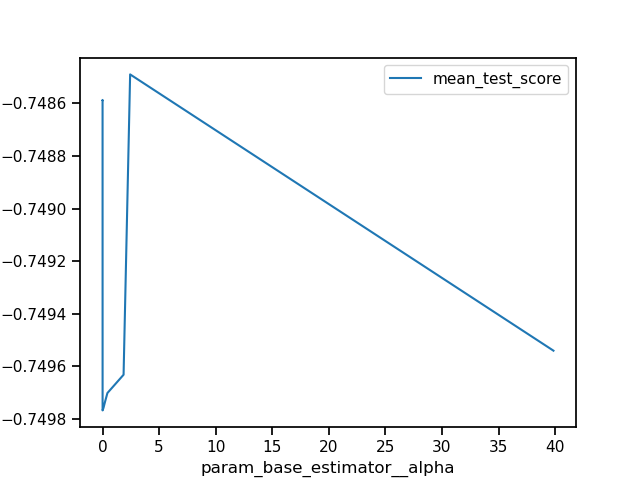

time: 211 ms


In [11]:
print(model.best_score_)
print(model.best_params_)
results_df = (
    pd.DataFrame(model.cv_results_)
    .sort_values(by="param_base_estimator__alpha", ascending=True)
    .loc[:, ["param_base_estimator__alpha", "mean_test_score"]]
)
results_df.plot(x="param_base_estimator__alpha", y="mean_test_score")
plt.show()

In [12]:
df = pd.DataFrame(model.cv_results_)
df.param_base_estimator__class_weight = df.param_base_estimator__class_weight.astype(
    str
)
df.groupby("param_base_estimator__class_weight").mean()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,mean_test_score,std_test_score,rank_test_score
param_base_estimator__class_weight,,,,,,,,,,,,,,
None,0.875759,0.071242,0.116763,0.047053,-0.725115,-0.722108,-0.883914,-0.768143,-0.666875,-0.713444,-0.760281,-0.748554,0.063242,2.0
balanced,0.957302,0.126302,0.119950,0.051322,-0.725205,-0.719937,-0.887761,-0.768557,-0.667003,-0.717115,-0.762326,-0.749700,0.064323,7.0


time: 17.1 ms


In [13]:
def tune(alpha: Sequence, results_df: pd.DataFrame, n_iter: int = 10) -> pd.DataFrame:
    """Run tuning procedure"""
    model = RandomizedSearchCV(
        estimator=CalibratedClassifierCV(
            base_estimator=RidgeClassifier(random_state=SEED + 1, class_weight=None),
            method="isotonic",
            n_jobs=-1,
        ),
        param_distributions={"base_estimator__alpha": alpha},
        n_iter=n_iter,
        scoring="neg_log_loss",
        n_jobs=-1,
        cv=list(cross_validator()),
        verbose=1,
        random_state=SEED + 2,
        error_score="raise",
    ).fit(data, labels.valence)

    print("best score:", model.best_score_)
    print("best params:", model.best_params_)
    df = (
        pd.DataFrame(model.cv_results_)
        .sort_values(by="param_base_estimator__alpha", ascending=True)
        .loc[:, ["param_base_estimator__alpha", "mean_test_score"]]
    )
    df.plot(x="param_base_estimator__alpha", y="mean_test_score")
    plt.show()
    return pd.concat(
        [results_df.loc[:, ["param_base_estimator__alpha", "mean_test_score"]], df],
        axis="rows",
    )


_ = gc_collect()

time: 115 ms


Fitting 7 folds for each of 10 candidates, totalling 70 fits
best score: -0.7482096455562861
best params: {'base_estimator__alpha': 23.090900086512427}


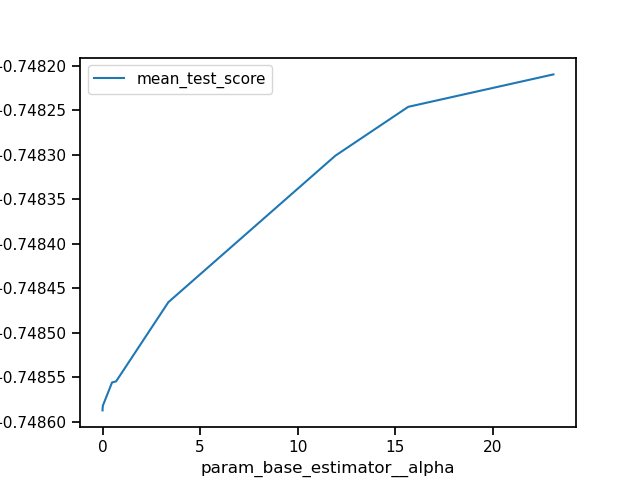

Fitting 7 folds for each of 10 candidates, totalling 70 fits
best score: -0.7479331311372367
best params: {'base_estimator__alpha': 106.06387447626572}


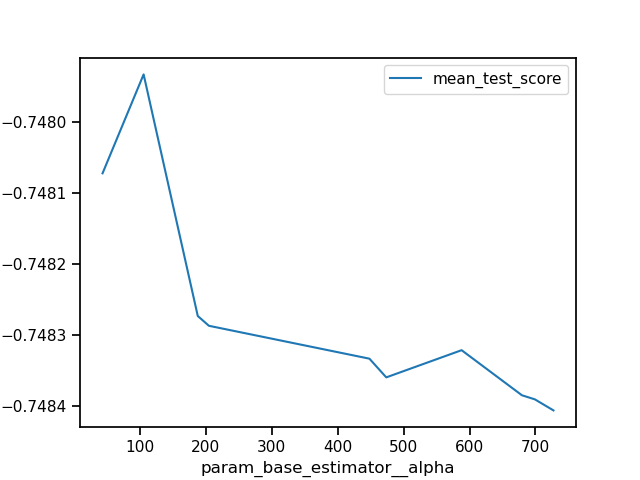

time: 24.3 s


In [14]:
df = tune(alpha=loguniform(1e-3, 1e3), results_df=df, n_iter=10)
df = tune(alpha=uniform(1e-3, 1e3), results_df=df, n_iter=10)

Fitting 7 folds for each of 10 candidates, totalling 70 fits
best score: -0.7483398909498266
best params: {'base_estimator__alpha': 8.108874421334596}


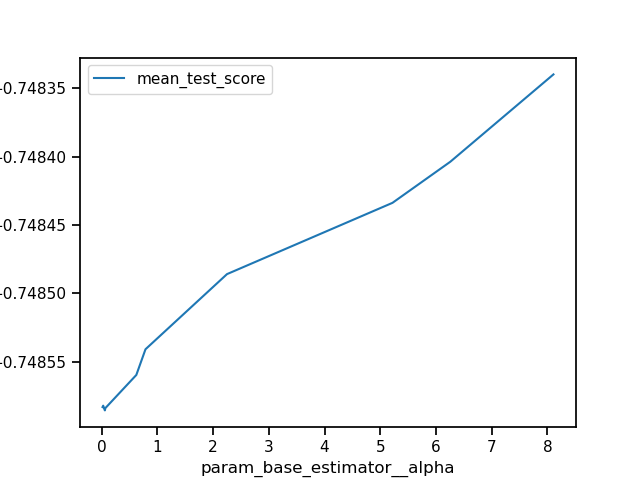

Fitting 7 folds for each of 10 candidates, totalling 70 fits
best score: -0.7479628284319686
best params: {'base_estimator__alpha': 67.95005235251416}


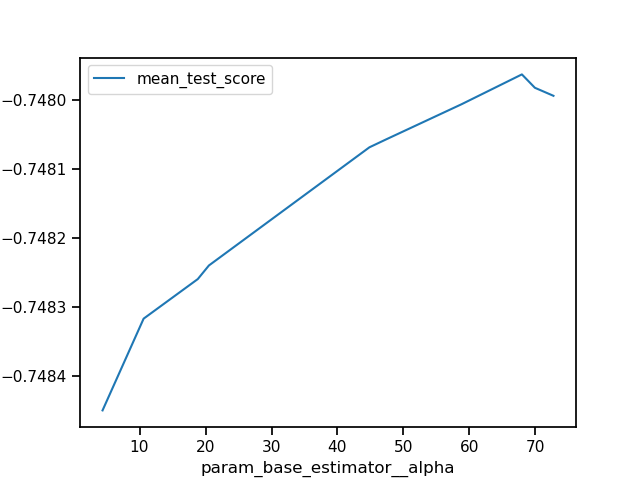

time: 23.8 s


In [15]:
df = tune(alpha=loguniform(1e-2, 1e2), results_df=df, n_iter=10)
df = tune(alpha=uniform(1e-2, 1e2), results_df=df, n_iter=10)

Fitting 7 folds for each of 10 candidates, totalling 70 fits
best score: -0.7485070143600716
best params: {'base_estimator__alpha': 1.5195690206934473}


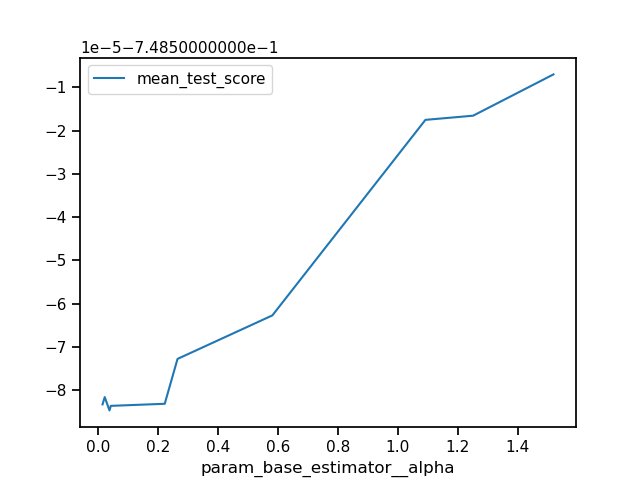

Fitting 7 folds for each of 10 candidates, totalling 70 fits
best score: -0.7483624817842333
best params: {'base_estimator__alpha': 7.282401436844547}


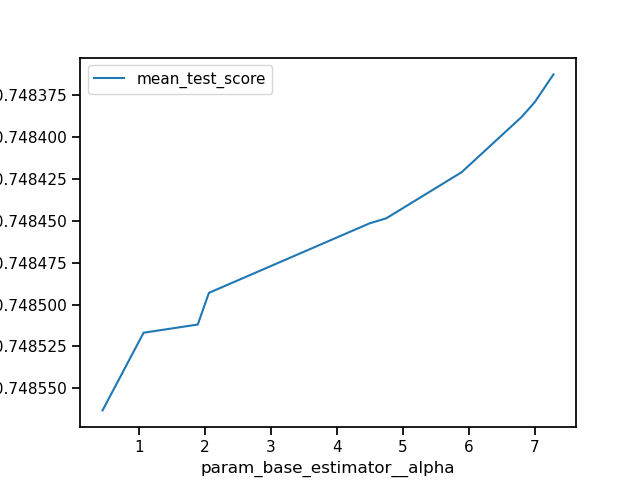

time: 24 s


In [16]:
df = tune(alpha=loguniform(1e-2, 10), results_df=df, n_iter=10)
df = tune(alpha=uniform(1e-2, 10), results_df=df, n_iter=10)

Fitting 7 folds for each of 10 candidates, totalling 70 fits
best score: -0.7485533269137427
best params: {'base_estimator__alpha': 0.4779698731533934}


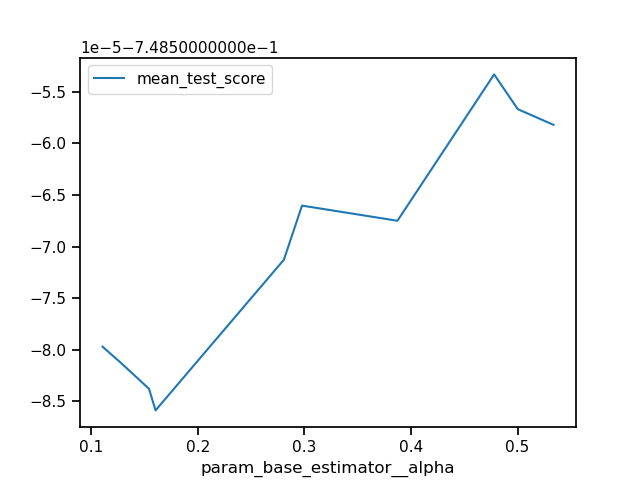

Fitting 7 folds for each of 10 candidates, totalling 70 fits
best score: -0.7485353251202483
best params: {'base_estimator__alpha': 0.8272401436844548}


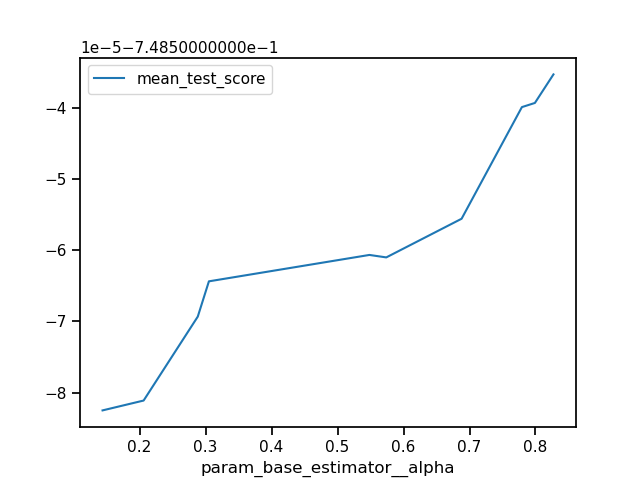

time: 23.2 s


In [17]:
df = tune(alpha=loguniform(0.1, 1), results_df=df, n_iter=10)
df = tune(alpha=uniform(0.1, 1), results_df=df, n_iter=10)

Fitting 7 folds for each of 10 candidates, totalling 70 fits
best score: -0.7485177342113908
best params: {'base_estimator__alpha': 1.0777788260091068}


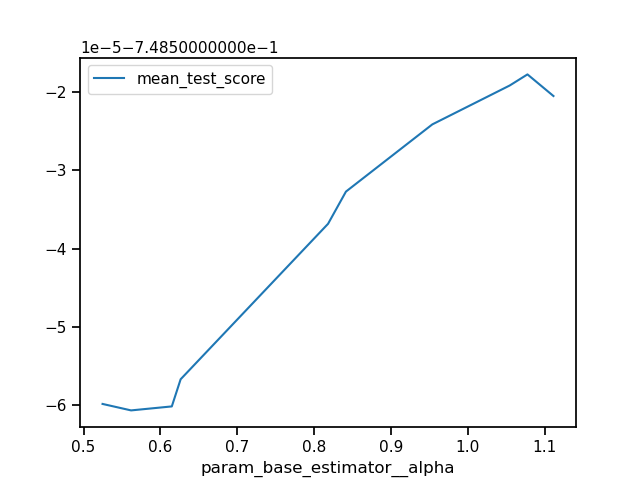

Fitting 7 folds for each of 10 candidates, totalling 70 fits
best score: -0.7485061792213156
best params: {'base_estimator__alpha': 1.5908602155266822}


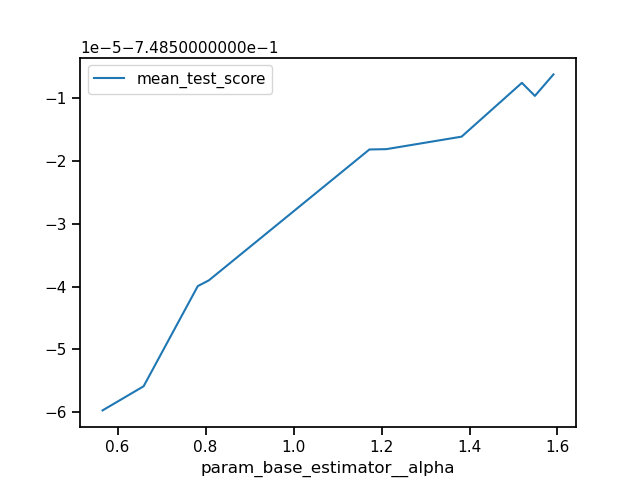

time: 23.4 s


In [18]:
df = tune(alpha=loguniform(0.5, 1.5), results_df=df, n_iter=10)
df = tune(alpha=uniform(0.5, 1.5), results_df=df, n_iter=10)

Fitting 7 folds for each of 10 candidates, totalling 70 fits
best score: -0.7485261523342663
best params: {'base_estimator__alpha': 0.9121672629709177}


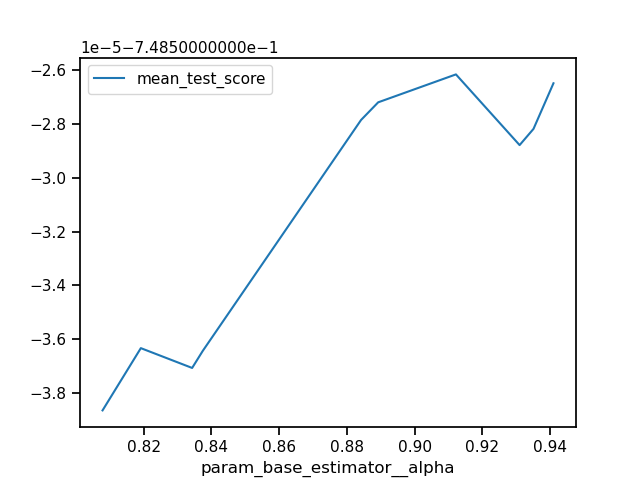

Fitting 7 folds for each of 10 candidates, totalling 70 fits
best score: -0.7485074117591649
best params: {'base_estimator__alpha': 1.527240143684455}


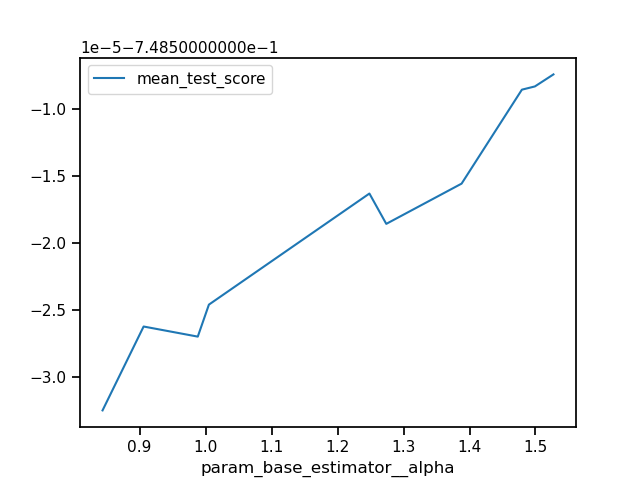

time: 24.1 s


In [19]:
df = tune(alpha=loguniform(0.8, 1.0), results_df=df, n_iter=10)
df = tune(alpha=uniform(0.8, 1.0), results_df=df, n_iter=10)

Fitting 7 folds for each of 10 candidates, totalling 70 fits
best score: -0.7485205262932855
best params: {'base_estimator__alpha': 1.0414096933928414}


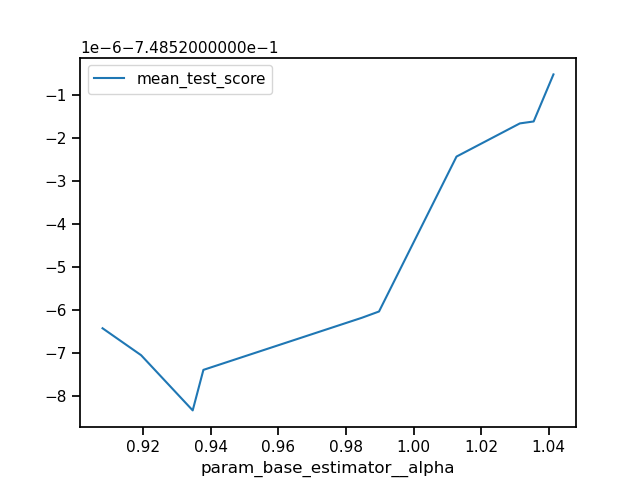

Fitting 7 folds for each of 10 candidates, totalling 70 fits
best score: -0.748506769316334
best params: {'base_estimator__alpha': 1.6999641580529004}


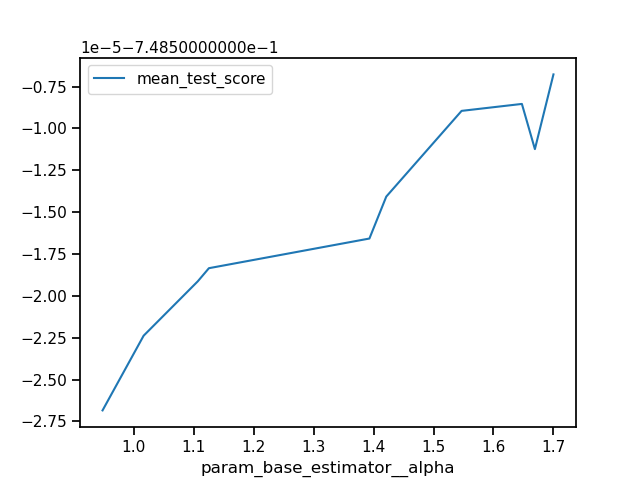

time: 23.4 s


In [20]:
df = tune(alpha=loguniform(0.9, 1.1), results_df=df, n_iter=10)
df = tune(alpha=uniform(0.9, 1.1), results_df=df, n_iter=10)

Fitting 7 folds for each of 10 candidates, totalling 70 fits
best score: -0.747837107006799
best params: {'base_estimator__alpha': 2309.0900086512424}


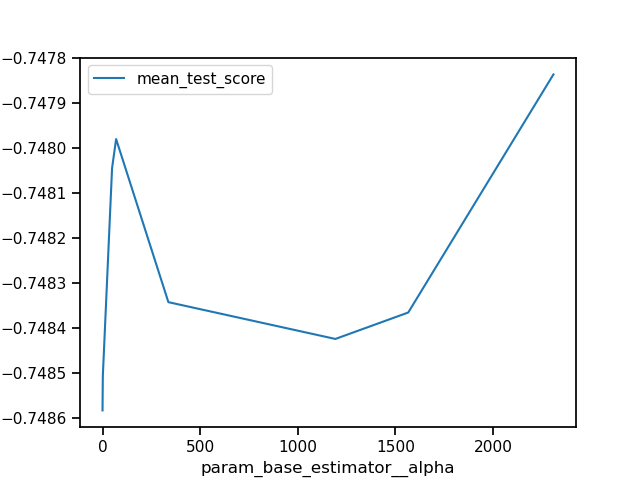

Fitting 7 folds for each of 10 candidates, totalling 70 fits
best score: -0.7450099265337663
best params: {'base_estimator__alpha': 72724.11436844549}


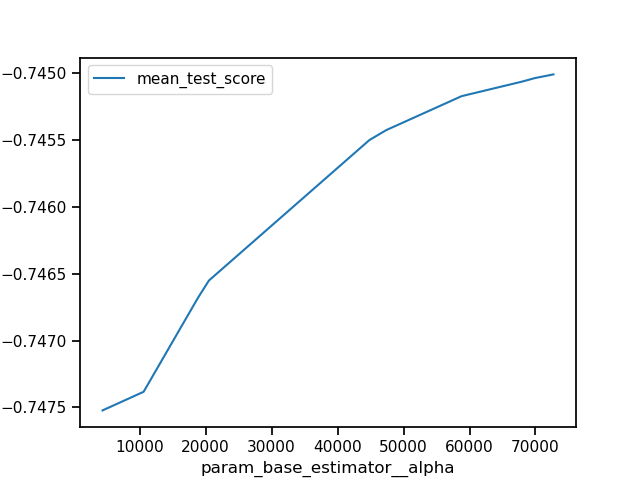

time: 24.2 s


In [21]:
df = tune(alpha=loguniform(0.1, 1e5), results_df=df, n_iter=10)
df = tune(alpha=uniform(0.1, 1e5), results_df=df, n_iter=10)

Fitting 7 folds for each of 10 candidates, totalling 70 fits
best score: -0.7449947264142354
best params: {'base_estimator__alpha': 108308.46985724186}


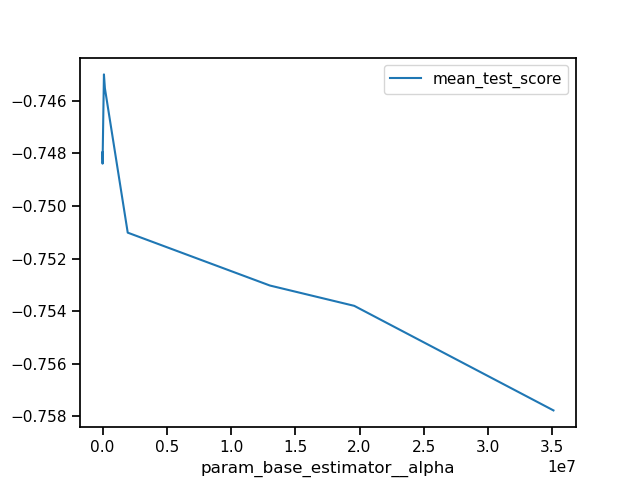

Fitting 7 folds for each of 10 candidates, totalling 70 fits
best score: -0.7941555970678416
best params: {'base_estimator__alpha': 438085647.46864814}


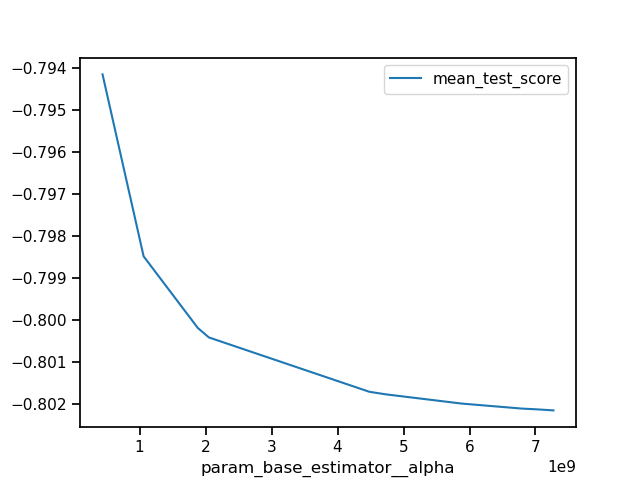

time: 24.2 s


In [22]:
df = tune(alpha=loguniform(10, 1e10), results_df=df, n_iter=10)
df = tune(alpha=uniform(10, 1e10), results_df=df, n_iter=10)

Fitting 7 folds for each of 10 candidates, totalling 70 fits
best score: -0.7446622256249226
best params: {'base_estimator__alpha': 87110.91880089794}


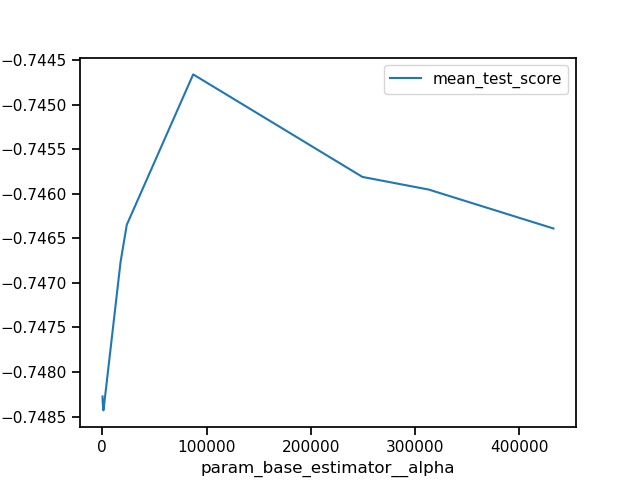

Fitting 7 folds for each of 10 candidates, totalling 70 fits
best score: -0.7464393718494151
best params: {'base_estimator__alpha': 438185.63746864814}


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\pandas\plotting\_matplotlib\core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


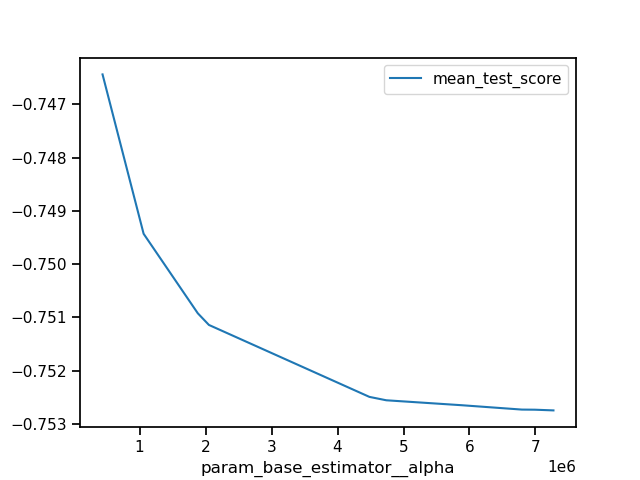

time: 24.5 s


In [23]:
df = tune(alpha=loguniform(100, 1e7), results_df=df, n_iter=10)
df = tune(alpha=uniform(100, 1e7), results_df=df, n_iter=10)

Fitting 7 folds for each of 10 candidates, totalling 70 fits
best score: -0.7450113552180457
best params: {'base_estimator__alpha': 109194.70279424937}


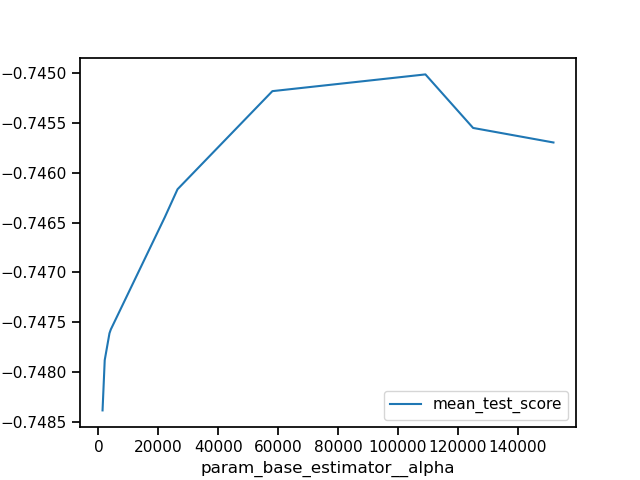

Fitting 7 folds for each of 10 candidates, totalling 70 fits
best score: -0.7449657158018119
best params: {'base_estimator__alpha': 107062.87447626573}


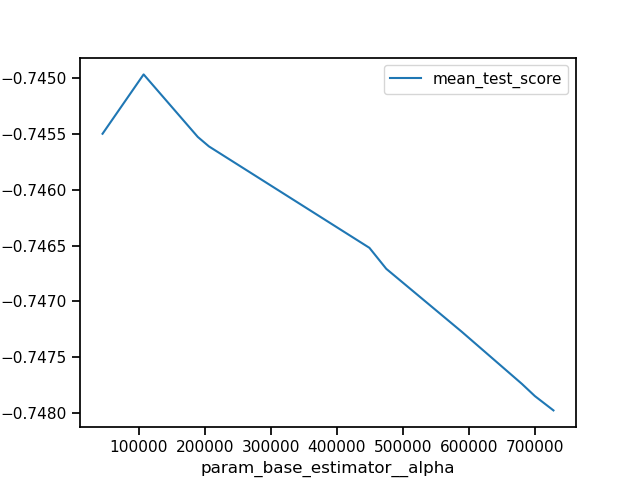

time: 24.2 s


In [24]:
df = tune(alpha=loguniform(1000, 1e6), results_df=df, n_iter=10)
df = tune(alpha=uniform(1000, 1e6), results_df=df, n_iter=10)

Fitting 7 folds for each of 10 candidates, totalling 70 fits
best score: -0.7449931816384663
best params: {'base_estimator__alpha': 110613.60936306213}


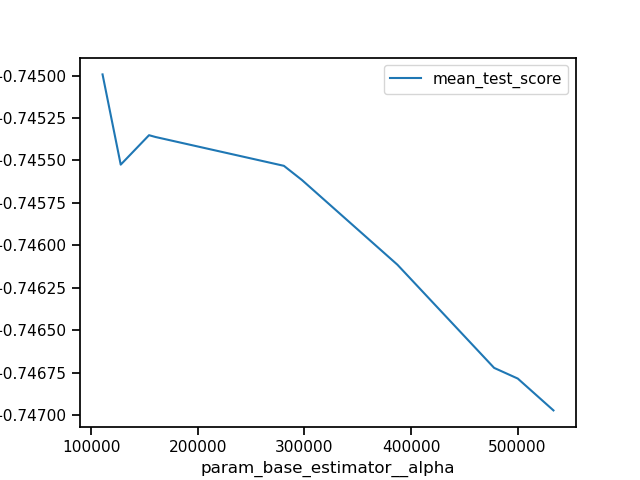

Fitting 7 folds for each of 10 candidates, totalling 70 fits
best score: -0.7456099529375668
best params: {'base_estimator__alpha': 206062.87447626574}


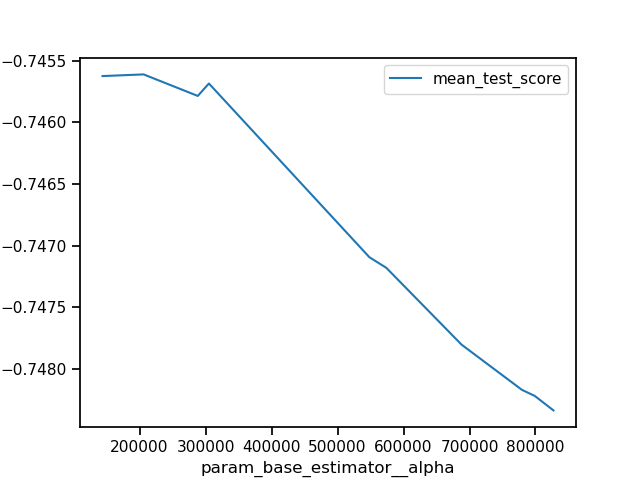

time: 23.9 s


In [25]:
df = tune(alpha=loguniform(1e5, 1e6), results_df=df, n_iter=10)
df = tune(alpha=uniform(1e5, 1e6), results_df=df, n_iter=10)

Fitting 7 folds for each of 50 candidates, totalling 350 fits
best score: -0.7446244720518457
best params: {'base_estimator__alpha': 92412.89396609525}


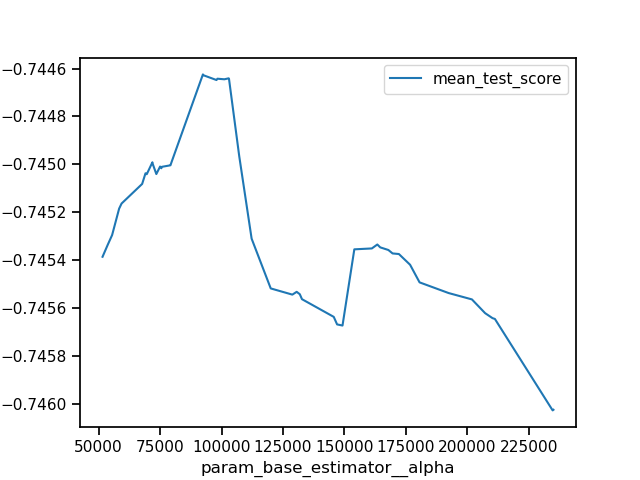

Fitting 7 folds for each of 50 candidates, totalling 350 fits
best score: -0.744629817626055
best params: {'base_estimator__alpha': 106338.54079817388}


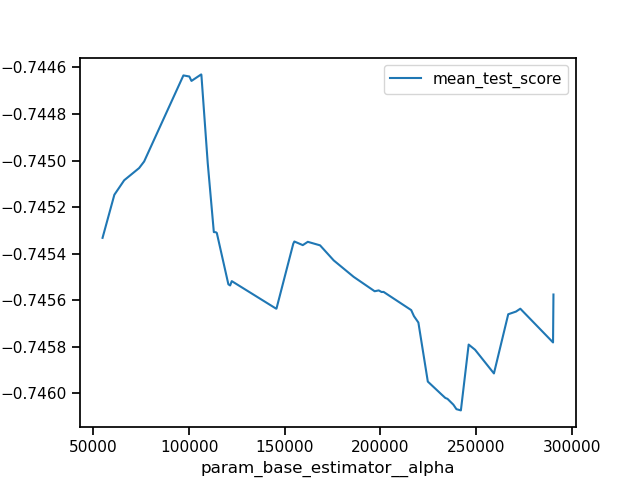

time: 1min 44s


In [26]:
df = tune(alpha=loguniform(50000, 250000), results_df=df, n_iter=50)
df = tune(alpha=uniform(50000, 250000), results_df=df, n_iter=50)

Fitting 7 folds for each of 50 candidates, totalling 350 fits
best score: -0.744616600614086
best params: {'base_estimator__alpha': 93792.7514477731}


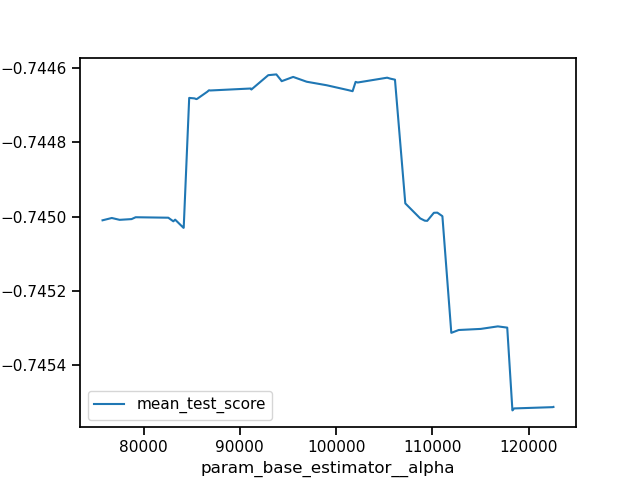

Fitting 7 folds for each of 50 candidates, totalling 350 fits
best score: -0.7446235126406056
best params: {'base_estimator__alpha': 104873.35405446612}


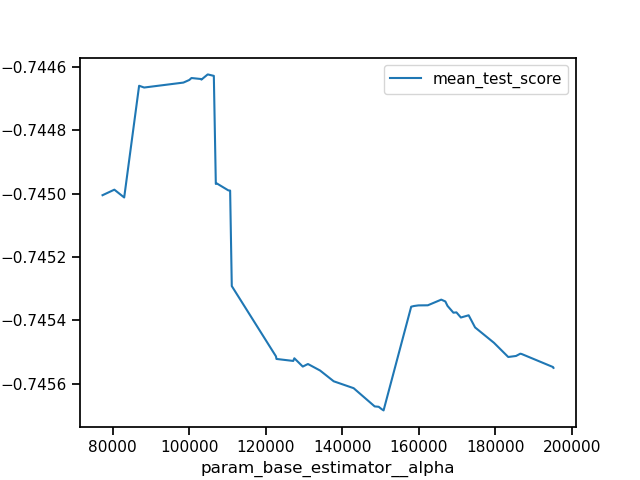

time: 1min 40s


In [27]:
df = tune(alpha=loguniform(75000, 125000), results_df=df, n_iter=50)
df = tune(alpha=uniform(75000, 125000), results_df=df, n_iter=50)

Fitting 7 folds for each of 15 candidates, totalling 105 fits
best score: -0.7483405328868938
best params: {'base_estimator__alpha': 8.38600564896727}


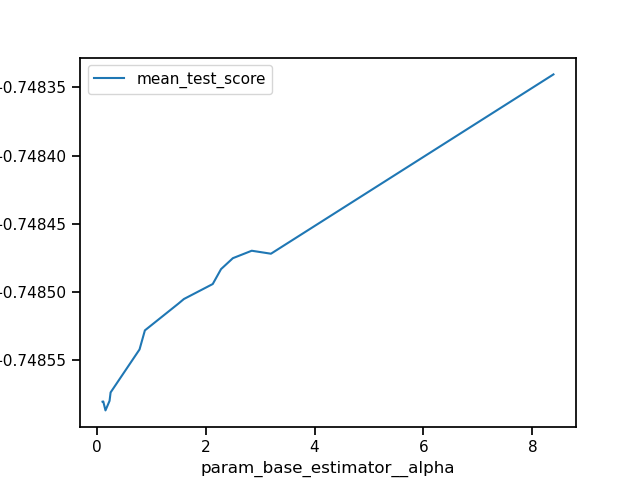

Fitting 7 folds for each of 15 candidates, totalling 105 fits
best score: -0.7483312382550853
best params: {'base_estimator__alpha': 9.717775753081897}


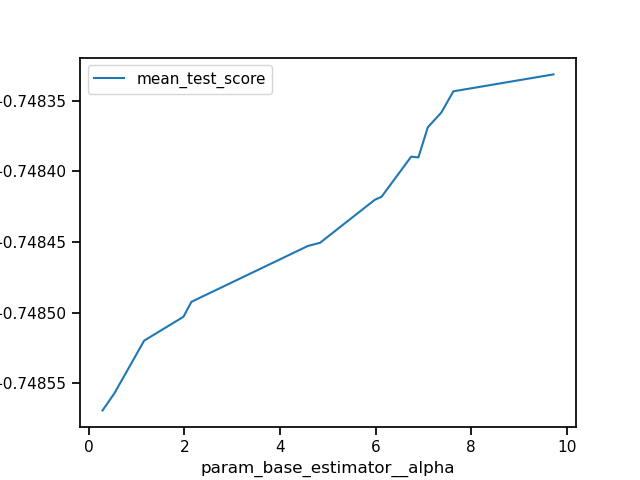

time: 33.8 s


In [28]:
df = tune(alpha=loguniform(0.1, 10), results_df=df, n_iter=15)
df = tune(alpha=uniform(0.1, 10), results_df=df, n_iter=15)

Fitting 7 folds for each of 15 candidates, totalling 105 fits
best score: -0.7446080398595489
best params: {'base_estimator__alpha': 93463.05784920669}


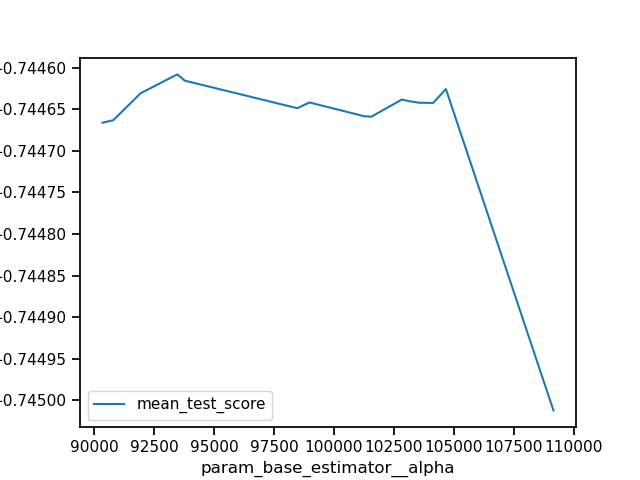

Fitting 7 folds for each of 15 candidates, totalling 105 fits
best score: -0.7446302087446198
best params: {'base_estimator__alpha': 92101.76426597126}


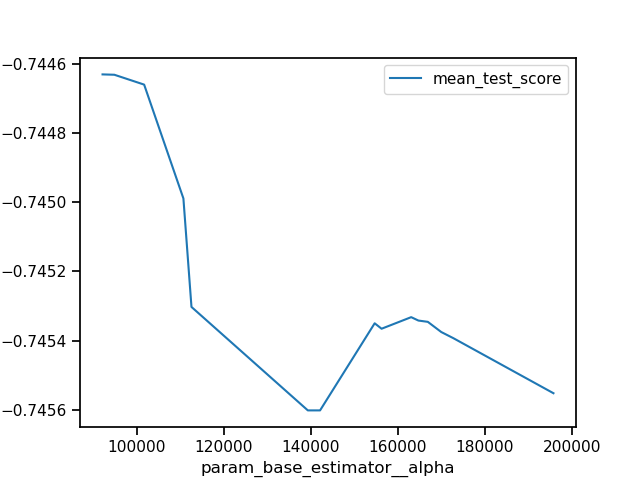

time: 34.4 s


In [29]:
df = tune(alpha=loguniform(90000, 110000), results_df=df, n_iter=15)
df = tune(alpha=uniform(90000, 110000), results_df=df, n_iter=15)

Fitting 7 folds for each of 50 candidates, totalling 350 fits
best score: -0.7446237464578481
best params: {'base_estimator__alpha': 95613.9406752829}


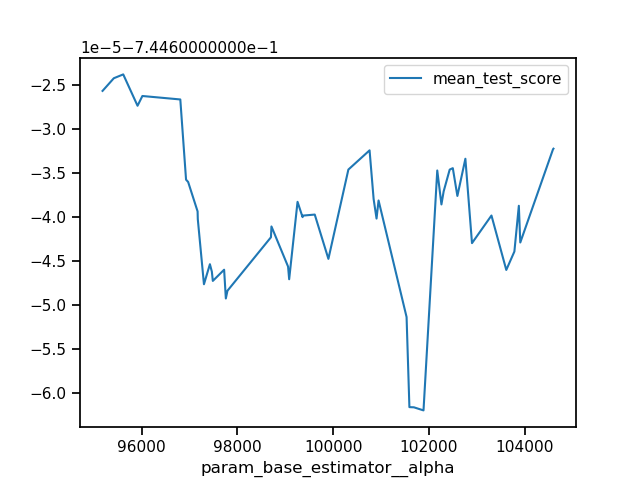

Fitting 7 folds for each of 50 candidates, totalling 350 fits
best score: -0.7446151696869742
best params: {'base_estimator__alpha': 96126.77081596348}


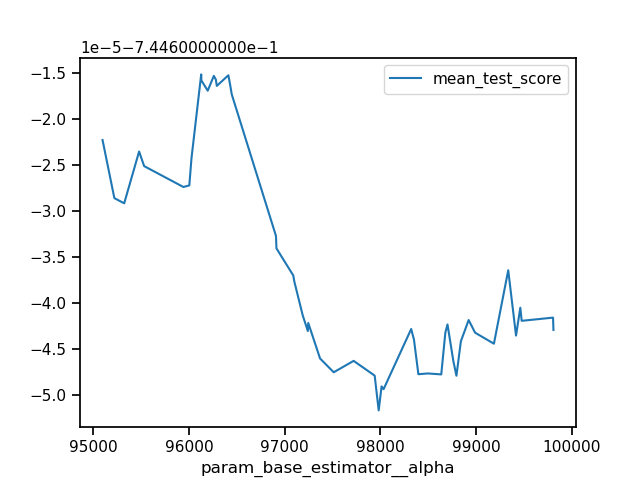

time: 1min 44s


In [30]:
df = tune(alpha=loguniform(95000, 105000), results_df=df, n_iter=50)
df = tune(alpha=uniform(95000, 5000), results_df=df, n_iter=50)
# I forgot the API goes center, scale for uniform and start, stop for loguniform

Fitting 7 folds for each of 50 candidates, totalling 350 fits
best score: -0.7446324652710493
best params: {'base_estimator__alpha': 100765.01412038332}


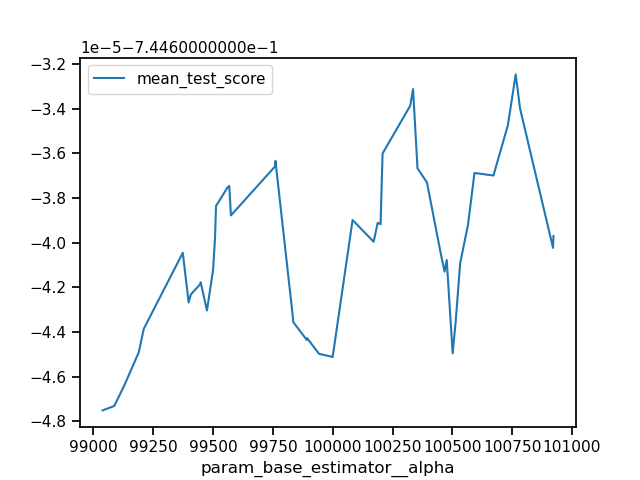

Fitting 7 folds for each of 50 candidates, totalling 350 fits
best score: -0.7446329343344142
best params: {'base_estimator__alpha': 100767.07740555317}


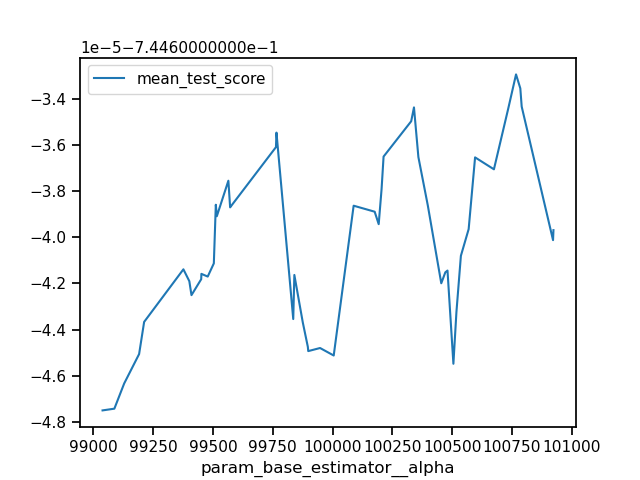

time: 1min 43s


In [31]:
df = tune(alpha=loguniform(99000, 101000), results_df=df, n_iter=50)
df = tune(alpha=uniform(99000, 2000), results_df=df, n_iter=50)

Fitting 7 folds for each of 30 candidates, totalling 210 fits
best score: -0.7446241829842017
best params: {'base_estimator__alpha': 95417.44316821704}


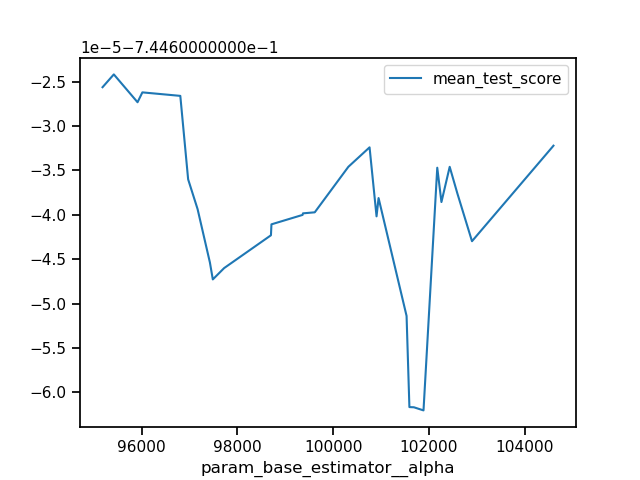

Fitting 7 folds for each of 30 candidates, totalling 210 fits
best score: -0.7446212503500717
best params: {'base_estimator__alpha': 95438.08563746864}


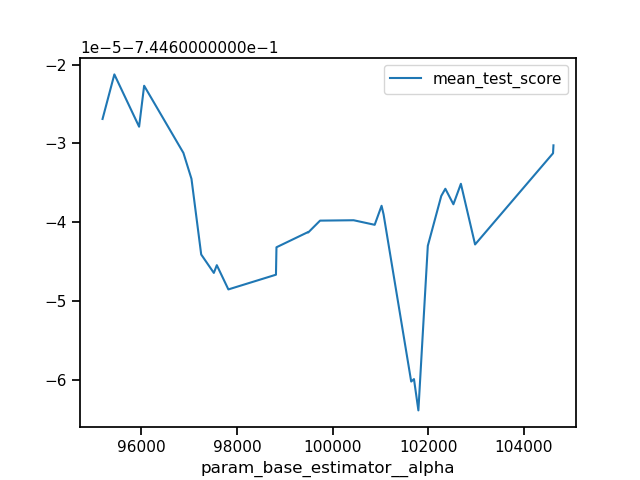

time: 1min 3s


In [32]:
df = tune(alpha=loguniform(95000, 105000), results_df=df, n_iter=30)
df = tune(alpha=uniform(95000, 10000), results_df=df, n_iter=30)

Fitting 7 folds for each of 25 candidates, totalling 175 fits
best score: -0.7446324127876327
best params: {'base_estimator__alpha': 100758.78942903526}


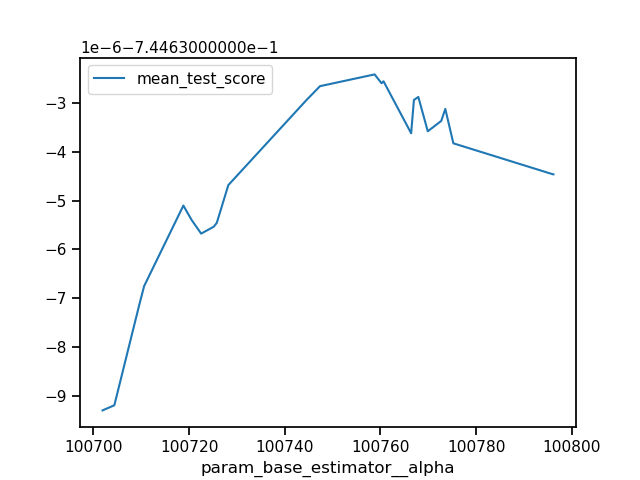

Fitting 7 folds for each of 25 candidates, totalling 175 fits
best score: -0.7446324128010667
best params: {'base_estimator__alpha': 100758.80145188954}


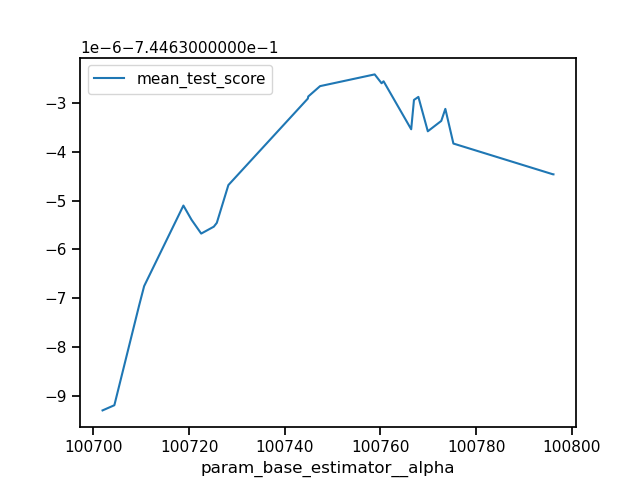

time: 53.7 s


In [33]:
df = tune(alpha=loguniform(100700, 100800), results_df=df, n_iter=25)
df = tune(alpha=uniform(100700, 100), results_df=df, n_iter=25)

In [34]:
results_df = df
results_df.columns = results_df.columns.astype(str)
results_df.reset_index(drop=True).to_csv(f"{DATA_OUT_FOLDER}/ridge_results.csv")

time: 11 ms


<AxesSubplot:xlabel='param_base_estimator__alpha'>

,param_base_estimator__alpha,mean_test_score
2,93463.057849,-0.744608
17,96126.770816,-0.744615
24,96410.825597,-0.744615
23,96258.836434,-0.744615
4,93779.939271,-0.744616
48,96279.604657,-0.744616
39,96128.843838,-0.744616
30,96429.136942,-0.744616
20,96289.97819,-0.744616
33,93792.751448,-0.744617


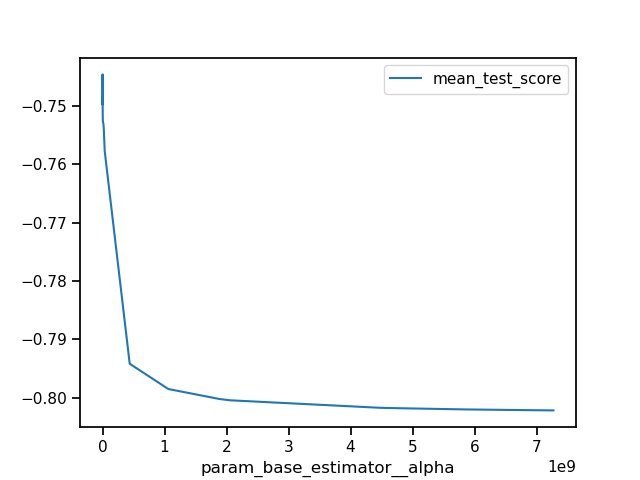

time: 211 ms


In [35]:
results_df = results_df.sort_values(by="param_base_estimator__alpha", ascending=True)
results_df.plot(x="param_base_estimator__alpha", y="mean_test_score")
df.sort_values(by="mean_test_score", ascending=False).head(100)

In [36]:
max_score = results_df.mean_test_score.max()
results_df.loc[results_df.mean_test_score == max_score]
results_df.loc[
    results_df.mean_test_score == max_score
].param_base_estimator__alpha.iloc[0]

,param_base_estimator__alpha,mean_test_score
2,93463.057849,-0.744608


93463.05784920669

time: 15.6 ms


<AxesSubplot:xlabel='param_base_estimator__alpha'>

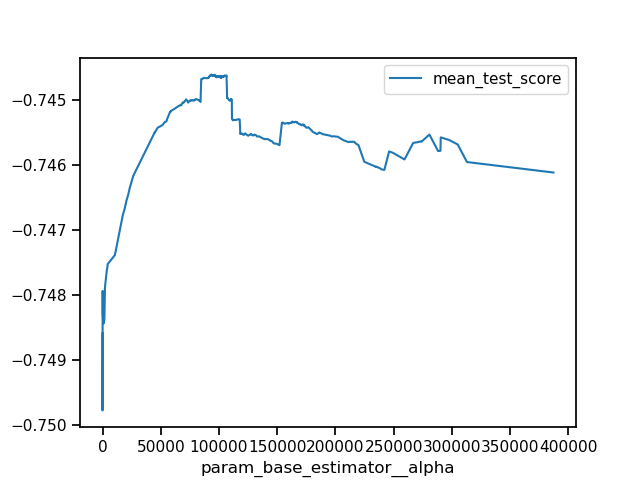

time: 160 ms


In [37]:
df = results_df.loc[results_df.param_base_estimator__alpha < 400000]
df.plot(x="param_base_estimator__alpha", y="mean_test_score")
plt.show()

<AxesSubplot:xlabel='param_base_estimator__alpha'>

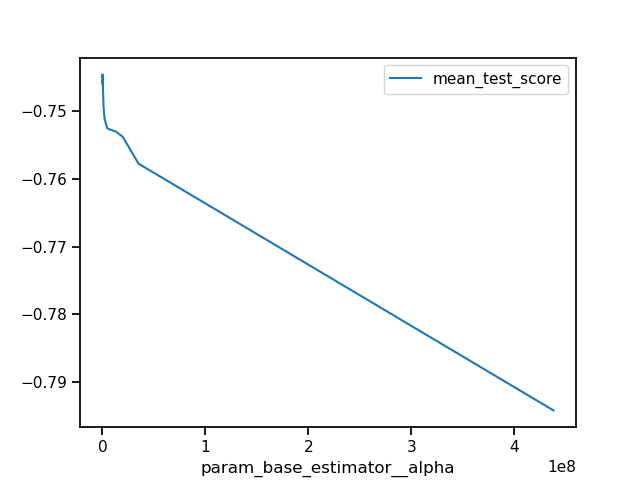

time: 126 ms


In [38]:
df = results_df.loc[results_df.param_base_estimator__alpha < 1e9]
df = df.loc[df.param_base_estimator__alpha > 75000]
df.plot(x="param_base_estimator__alpha", y="mean_test_score")
plt.show()

# Discussion

There are so many more possibilities for feature engineering. Upstream augmentation of the raw audio would probably be helpful as would resampling.

It's important to be disciplined now and focus on deployment. Although there are numerous points of interest where tweaking is likely to yield better results, we are only deviating slightly from the feature engineering pathway we already established.

In [39]:
print(f"Time elapsed since notebook_begin_time: {time() - notebook_begin_time} s")
_ = gc_collect()

Time elapsed since notebook_begin_time: 924.9536650180817 s
time: 183 ms


[^top](#Contents)